In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_2_singlegrid_half'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 1e-4,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.15,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[70,70,50], log_std_init=-1.7),
                verbose = 1,
                target_kl =0.1,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/coarse_grid_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


Using cuda device
seed 1: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 15 x 45


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f2acafe2da0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f2acaf7e908>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.71 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.705    |
| time/              |          |
|    fps             | 128      |
|    iterations      | 1        |
|    time_elapsed    | 19       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 54 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.689      |
| time/                   |            |
|    fps                  | 539        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |       

policy iteration runtime: 37 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.744       |
| time/                   |             |
|    fps                  | 535         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.055880927 |
|    clip_fraction        | 0.492       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.04        |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0603     |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0463     |
|    std                  | 

policy iteration runtime: 35 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.753       |
| time/                   |             |
|    fps                  | 563         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.059801735 |
|    clip_fraction        | 0.534       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.3         |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0205     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.048      |
|    std                  | 0.179       |
|    val

policy iteration runtime: 36 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.769      |
| time/                   |            |
|    fps                  | 551        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04893638 |
|    clip_fraction        | 0.531      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.57       |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0433    |
|    n_updates            | 500        |
|    policy_gradient_loss | -0.0393    |
|    std                  | 0.177      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.783      |
| time/                   |            |
|    fps                  | 542        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07687889 |
|    clip_fraction        | 0.562      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.87       |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0219    |
|    n_updates            | 660        |
|    policy_gradient_loss | -0.0423    |
|    std                  | 0.175      |
|    value_loss           |

policy iteration runtime: 42 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.796       |
| time/                   |             |
|    fps                  | 553         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.061329592 |
|    clip_fraction        | 0.562       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.4         |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0742     |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.0376     |
|    std                  | 0.17        |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.803       |
| time/                   |             |
|    fps                  | 539         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.072667316 |
|    clip_fraction        | 0.592       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.91        |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0174     |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0377     |
|    std                  |

policy iteration runtime: 39 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.812      |
| time/                   |            |
|    fps                  | 539        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07415295 |
|    clip_fraction        | 0.605      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.66       |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0329    |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.0353    |
|    std                  | 0.161      |
|    

policy iteration runtime: 45 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.817     |
| time/                   |           |
|    fps                  | 541       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0833801 |
|    clip_fraction        | 0.607     |
|    clip_range           | 0.15      |
|    entropy_loss         | 9.12      |
|    explained_variance   | 0.974     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0491   |
|    n_updates            | 1300      |
|    policy_gradient_loss | -0.0297   |
|    std                  | 0.158     |
|    value_loss          

policy iteration runtime: 36 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.824      |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08545439 |
|    clip_fraction        | 0.607      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.59       |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0588    |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0279    |
|    std                  | 0.155      |
|    

policy iteration runtime: 28 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.83        |
| time/                   |             |
|    fps                  | 541         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.093783416 |
|    clip_fraction        | 0.619       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.1        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0864     |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0243     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 526        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08890591 |
|    clip_fraction        | 0.627      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.5       |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00329    |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0287    |
|    std                  | 0.148      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 533        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09976198 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.1       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00726   |
|    n_updates            | 1940       |
|    policy_gradient_loss | -0.0275    |
|    std                  | 0.145      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.839      |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10593511 |
|    clip_fraction        | 0.627      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.5       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00722   |
|    n_updates            | 2100       |
|    policy_gradient_loss | -0.0245    |
|    std                  | 0.142      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.838      |
| time/                   |            |
|    fps                  | 544        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08592955 |
|    clip_fraction        | 0.631      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0222     |
|    n_updates            | 2260       |
|    policy_gradient_loss | -0.0204    |
|    std                  | 0.139      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.839      |
| time/                   |            |
|    fps                  | 547        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09812885 |
|    clip_fraction        | 0.639      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.3       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0115    |
|    n_updates            | 2420       |
|    policy_gradient_loss | -0.0179    |
|    std                  | 0.137      |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.842      |
| time/                   |            |
|    fps                  | 525        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11334898 |
|    clip_fraction        | 0.652      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0348    |
|    n_updates            | 2580       |
|    policy_gradient_loss | -0.0186    |
|    std                  | 0.134      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.843      |
| time/                   |            |
|    fps                  | 536        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10943552 |
|    clip_fraction        | 0.653      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.2       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00744   |
|    n_updates            | 2740       |
|    policy_gradient_loss | -0.0177    |
|    std                  | 0.131      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.844       |
| time/                   |             |
|    fps                  | 529         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.112019084 |
|    clip_fraction        | 0.665       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.6        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0183      |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.0178     |
|    std                  |

policy iteration runtime: 34 seconds

Total episode rollouts: 78336

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.844      |
| time/                   |            |
|    fps                  | 529        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13027593 |
|    clip_fraction        | 0.662      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0343    |
|    n_updates            | 3060       |
|    policy_gradient_loss | -0.0167    |
|    std                  | 0.127      |
|    

policy iteration runtime: 44 seconds

Total episode rollouts: 82432

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14168672 |
|    clip_fraction        | 0.671      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0109     |
|    n_updates            | 3220       |
|    policy_gradient_loss | -0.0137    |
|    std                  | 0.125      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 86528

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.846       |
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.122979105 |
|    clip_fraction        | 0.664       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.5        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0296     |
|    n_updates            | 3380        |
|    policy_gradient_loss | -0.0138     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 90624

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 531        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14856748 |
|    clip_fraction        | 0.676      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00521   |
|    n_updates            | 3540       |
|    policy_gradient_loss | -0.015     |
|    std                  | 0.122      |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 94720

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 539        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12996247 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.000362   |
|    n_updates            | 3700       |
|    policy_gradient_loss | -0.0132    |
|    std                  | 0.12       |
|    value_loss           |

policy iteration runtime: 39 seconds

Total episode rollouts: 98816

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 534        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14963189 |
|    clip_fraction        | 0.686      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0355    |
|    n_updates            | 3860       |
|    policy_gradient_loss | -0.0124    |
|    std                  | 0.119      |
|    

Early stopping at step 11 due to reaching max kl: 0.16
policy iteration runtime: 23 seconds

Total episode rollouts: 102912

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 526        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16296008 |
|    clip_fraction        | 0.668      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15         |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00263    |
|    n_updates            | 4020       |
|    policy_gradient_loss | -0.00106   |
|    std    

Early stopping at step 16 due to reaching max kl: 0.15
policy iteration runtime: 27 seconds

Total episode rollouts: 107008

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.848     |
| time/                   |           |
|    fps                  | 529       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1519984 |
|    clip_fraction        | 0.672     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.2      |
|    explained_variance   | 0.987     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.00195   |
|    n_updates            | 4180      |
|    policy_gradient_loss | -0.00485  |
|    std                  | 0.1

Early stopping at step 10 due to reaching max kl: 0.17
policy iteration runtime: 19 seconds

Total episode rollouts: 111104

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 543        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16742767 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0179     |
|    n_updates            | 4340       |
|    policy_gradient_loss | -0.00188   |
|    std    

Early stopping at step 16 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 115200

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 542        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15255275 |
|    clip_fraction        | 0.683      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.101     |
|    n_updates            | 4500       |
|    policy_gradient_loss | -0.011     |
|    std    

Early stopping at step 14 due to reaching max kl: 0.16
policy iteration runtime: 24 seconds

Total episode rollouts: 119296

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 546        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15578508 |
|    clip_fraction        | 0.684      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0402    |
|    n_updates            | 4660       |
|    policy_gradient_loss | -0.00598   |
|    std    

Early stopping at step 11 due to reaching max kl: 0.15
policy iteration runtime: 22 seconds

Total episode rollouts: 123392

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 543        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15075189 |
|    clip_fraction        | 0.677      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0161    |
|    n_updates            | 4820       |
|    policy_gradient_loss | 0.00134    |
|    std    

Early stopping at step 10 due to reaching max kl: 0.15
policy iteration runtime: 24 seconds

Total episode rollouts: 127488

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 524        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15215452 |
|    clip_fraction        | 0.658      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0205    |
|    n_updates            | 4980       |
|    policy_gradient_loss | 0.000878   |
|    std    

policy iteration runtime: 35 seconds

Total episode rollouts: 131584

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 539        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13760693 |
|    clip_fraction        | 0.686      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0538    |
|    n_updates            | 5140       |
|    policy_gradient_loss | -0.0133    |
|    std                  | 0.116      |
|    value_loss           

Early stopping at step 13 due to reaching max kl: 0.15
policy iteration runtime: 27 seconds

Total episode rollouts: 135680

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.849     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1540058 |
|    clip_fraction        | 0.682     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.8      |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.0692    |
|    n_updates            | 5300      |
|    policy_gradient_loss | -0.00439  |
|    std 

Early stopping at step 15 due to reaching max kl: 0.16
policy iteration runtime: 29 seconds

Total episode rollouts: 139776

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.85       |
| time/                   |            |
|    fps                  | 541        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15701202 |
|    clip_fraction        | 0.687      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0195     |
|    n_updates            | 5460       |
|    policy_gradient_loss | -0.

Early stopping at step 12 due to reaching max kl: 0.15
policy iteration runtime: 25 seconds

Total episode rollouts: 143872

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 543        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15095901 |
|    clip_fraction        | 0.674      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0739     |
|    n_updates            | 5620       |
|    policy_gradient_loss | -0.00535   |
|    std    

Early stopping at step 14 due to reaching max kl: 0.15
policy iteration runtime: 28 seconds

Total episode rollouts: 147968

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 528        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15300806 |
|    clip_fraction        | 0.688      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0609     |
|    n_updates            | 5780       |
|    policy_gradient_loss | -0.00518   |
|    std    

<IPython.core.display.Javascript object>


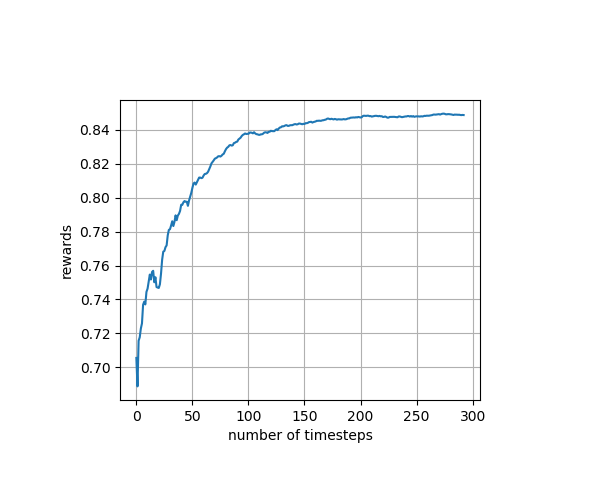

Using cuda device
seed 2: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 15 x 45


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f2acaf237b8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f2acaf8f9b0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.693      |
| time/                   |            |
|    fps                  | 141        |
|    iterations           | 1          |
|    time_elapsed         | 18         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13773409 |
|    clip_fraction        | 0.688      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.116      |
|    n_updates            | 5860       |
|    policy_gradient_loss | -0.0128    |
|    std                  | 0.116      |
|    value_loss           | 0.000773   |
---------------------------------

policy iteration runtime: 36 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.726      |
| time/                   |            |
|    fps                  | 616        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05065584 |
|    clip_fraction        | 0.49       |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.03       |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0345    |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.0442    |
|    std                  | 0.182      |
|    v

policy iteration runtime: 36 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.743      |
| time/                   |            |
|    fps                  | 620        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04759901 |
|    clip_fraction        | 0.513      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.18       |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0699    |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0459    |
|    std                  | 0.18       |
|    value_loss           | 

policy iteration runtime: 35 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.751       |
| time/                   |             |
|    fps                  | 600         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.057744734 |
|    clip_fraction        | 0.541       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.62        |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0825     |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0465     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.753      |
| time/                   |            |
|    fps                  | 638        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06941149 |
|    clip_fraction        | 0.555      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.9        |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0768    |
|    n_updates            | 640        |
|    policy_gradient_loss | -0.042     |
|    std                  | 0.174      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.764     |
| time/                   |           |
|    fps                  | 616       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0723149 |
|    clip_fraction        | 0.565     |
|    clip_range           | 0.15      |
|    entropy_loss         | 7.2       |
|    explained_variance   | 0.965     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0841   |
|    n_updates            | 800       |
|    policy_gradient_loss | -0.0412   |
|    std                  | 0.172     |
|    value_loss          

policy iteration runtime: 33 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.778       |
| time/                   |             |
|    fps                  | 580         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.084320545 |
|    clip_fraction        | 0.586       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.61        |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0872     |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0389     |
|    std                  |

policy iteration runtime: 41 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.803      |
| time/                   |            |
|    fps                  | 622        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07139013 |
|    clip_fraction        | 0.594      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.08       |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0572    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0375    |
|    std                  | 0.165      |
|    

policy iteration runtime: 37 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.816       |
| time/                   |             |
|    fps                  | 632         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.066383615 |
|    clip_fraction        | 0.604       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.66        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0361      |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.0347     |
|    std                  |

policy iteration runtime: 43 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.821      |
| time/                   |            |
|    fps                  | 632        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06868534 |
|    clip_fraction        | 0.625      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.11       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.059     |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0323    |
|    std                  | 0.157      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.829      |
| time/                   |            |
|    fps                  | 626        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08277128 |
|    clip_fraction        | 0.621      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.58       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00828    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0276    |
|    std                  | 0.154      |
|    

policy iteration runtime: 40 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.838       |
| time/                   |             |
|    fps                  | 632         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.088889554 |
|    clip_fraction        | 0.622       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0971     |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0198     |
|    std                  |

policy iteration runtime: 43 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.844      |
| time/                   |            |
|    fps                  | 633        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09352524 |
|    clip_fraction        | 0.626      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.7       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0458     |
|    n_updates            | 1920       |
|    policy_gradient_loss | -0.0171    |
|    std                  | 0.146      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.846       |
| time/                   |             |
|    fps                  | 623         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.095015995 |
|    clip_fraction        | 0.615       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.1        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.033       |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0125     |
|    std                  |

policy iteration runtime: 35 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.849     |
| time/                   |           |
|    fps                  | 625       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1096976 |
|    clip_fraction        | 0.625     |
|    clip_range           | 0.15      |
|    entropy_loss         | 11.5      |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.044     |
|    n_updates            | 2240      |
|    policy_gradient_loss | -0.0172   |
|    std                  | 0.141     |
|    value_loss          

policy iteration runtime: 34 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 622        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10332062 |
|    clip_fraction        | 0.622      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.8       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0243     |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.00819   |
|    std                  | 0.139      |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.852      |
| time/                   |            |
|    fps                  | 615        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09323658 |
|    clip_fraction        | 0.641      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.2       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0249    |
|    n_updates            | 2560       |
|    policy_gradient_loss | -0.0132    |
|    std                  | 0.137      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 629        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12958468 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.4       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0146    |
|    n_updates            | 2720       |
|    policy_gradient_loss | -0.0129    |
|    std                  | 0.135      |
|    value_loss           |

policy iteration runtime: 34 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 616        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10336287 |
|    clip_fraction        | 0.641      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00114    |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0093    |
|    std                  | 0.133      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 642        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13101217 |
|    clip_fraction        | 0.641      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.9       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0667     |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.00962   |
|    std                  | 0.132      |
|    value_loss           |

policy iteration runtime: 31 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.854      |
| time/                   |            |
|    fps                  | 631        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11865421 |
|    clip_fraction        | 0.65       |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.1       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0444    |
|    n_updates            | 3200       |
|    policy_gradient_loss | -0.0123    |
|    std                  | 0.132      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.855       |
| time/                   |             |
|    fps                  | 620         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.112709686 |
|    clip_fraction        | 0.645       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.4        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.076      |
|    n_updates            | 3360        |
|    policy_gradient_loss | -0.00617    |
|    std                  |

policy iteration runtime: 35 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.855     |
| time/                   |           |
|    fps                  | 639       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1292196 |
|    clip_fraction        | 0.648     |
|    clip_range           | 0.15      |
|    entropy_loss         | 13.7      |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0364   |
|    n_updates            | 3520      |
|    policy_gradient_loss | -0.00225  |
|    std                  | 0.128     |
|    value_loss           | 0.000456  |
-------

policy iteration runtime: 32 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 620        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13872279 |
|    clip_fraction        | 0.661      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0471    |
|    n_updates            | 3680       |
|    policy_gradient_loss | -0.00662   |
|    std                  | 0.127      |
|    value_loss           |

policy iteration runtime: 31 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 637        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14296728 |
|    clip_fraction        | 0.662      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14         |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00435   |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.00844   |
|    std                  | 0.126      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 624        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11803713 |
|    clip_fraction        | 0.661      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.1       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00854    |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.00476   |
|    std                  | 0.126      |
|    value_loss           

Early stopping at step 14 due to reaching max kl: 0.15
policy iteration runtime: 26 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 644        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15093522 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0142     |
|    n_updates            | 4160       |
|    policy_gradient_loss | 0.0

policy iteration runtime: 32 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 617        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13033035 |
|    clip_fraction        | 0.668      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0583     |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.00559   |
|    std                  | 0.124      |
|    value_loss           

policy iteration runtime: 35 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 635        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13957016 |
|    clip_fraction        | 0.672      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0355    |
|    n_updates            | 4480       |
|    policy_gradient_loss | -0.0052    |
|    std                  | 0.124      |
|   

Early stopping at step 12 due to reaching max kl: 0.15
policy iteration runtime: 22 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 623        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15108988 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0259     |
|    n_updates            | 4640       |
|    policy_gradient_loss | 0.0105     |
|    std    

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 32 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 632        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15745611 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0228     |
|    n_updates            | 4800       |
|    policy_gradient_loss | -0.00282   |
|    std    

policy iteration runtime: 38 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 654        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11546872 |
|    clip_fraction        | 0.683      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15         |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0331    |
|    n_updates            | 4960       |
|    policy_gradient_loss | -0.00384   |
|    std                  | 0.122      |
|    value_loss           

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 27 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.857     |
| time/                   |           |
|    fps                  | 637       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1547633 |
|    clip_fraction        | 0.674     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.9      |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0502   |
|    n_updates            | 5120      |
|    policy_gradient_loss | 0.00414   |
|    std                  | 0.1

Early stopping at step 15 due to reaching max kl: 0.16
policy iteration runtime: 25 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 628        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16051136 |
|    clip_fraction        | 0.675      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0163     |
|    n_updates            | 5280       |
|    policy_gradient_loss | 0.0

Early stopping at step 10 due to reaching max kl: 0.15
policy iteration runtime: 23 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 624        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15162161 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.017      |
|    n_updates            | 5440       |
|    policy_gradient_loss | 0.00752    |
|    std    

Early stopping at step 11 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.857     |
| time/                   |           |
|    fps                  | 623       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1515427 |
|    clip_fraction        | 0.668     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.8      |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.027    |
|    n_updates            | 5600      |
|    policy_gradient_loss | 0.00503   |
|    std                  | 0.1

Early stopping at step 16 due to reaching max kl: 0.15
policy iteration runtime: 27 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 633        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15015364 |
|    clip_fraction        | 0.676      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0319     |
|    n_updates            | 5760       |
|    policy_gradient_loss | 0.00109    |
|    std    

<IPython.core.display.Javascript object>


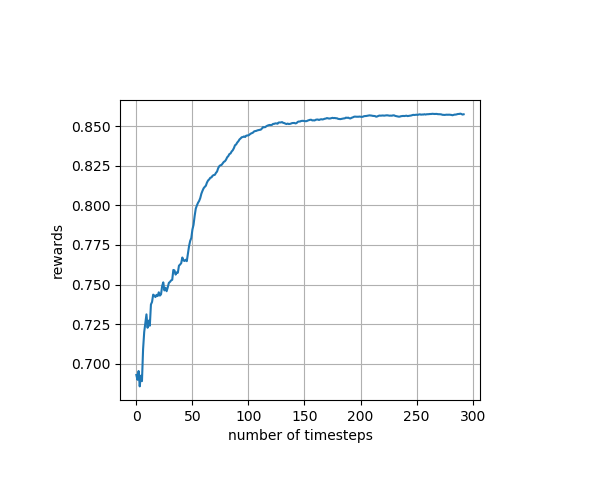

Using cuda device
seed 3: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 15 x 45


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f2a98051e10> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f2a90070400>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.696      |
| time/                   |            |
|    fps                  | 139        |
|    iterations           | 1          |
|    time_elapsed         | 18         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15118256 |
|    clip_fraction        | 0.672      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0639    |
|    n_updates            | 5860       |
|    policy_gradient_loss | 0.00292    |
|    std                  | 0.123      |
|    value_loss           | 0.000573   |
---------------------------------

policy iteration runtime: 45 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.72 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.723     |
| time/                   |           |
|    fps                  | 625       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0371707 |
|    clip_fraction        | 0.49      |
|    clip_range           | 0.15      |
|    entropy_loss         | 6         |
|    explained_variance   | 0.947     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0516   |
|    n_updates            | 160       |
|    policy_gradient_loss | -0.0464   |
|    std                  | 0.182     |
|    value_loss           | 0.00226   |
--------

policy iteration runtime: 38 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.75        |
| time/                   |             |
|    fps                  | 621         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.047296397 |
|    clip_fraction        | 0.525       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.26        |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0684     |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0446     |
|    std                  | 

policy iteration runtime: 33 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.755      |
| time/                   |            |
|    fps                  | 614        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06403508 |
|    clip_fraction        | 0.546      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.76       |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0525    |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0451    |
|    std                  | 0.175      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.764     |
| time/                   |           |
|    fps                  | 640       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0641596 |
|    clip_fraction        | 0.552     |
|    clip_range           | 0.15      |
|    entropy_loss         | 7.04      |
|    explained_variance   | 0.963     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0278   |
|    n_updates            | 640       |
|    policy_gradient_loss | -0.0408   |
|    std                  | 0.173     |
|    value_loss           | 0.00176   |
-------

policy iteration runtime: 33 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.777      |
| time/                   |            |
|    fps                  | 643        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06758753 |
|    clip_fraction        | 0.577      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.44       |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0599    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0385    |
|    std                  | 0.17       |
|    

policy iteration runtime: 25 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.794      |
| time/                   |            |
|    fps                  | 645        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09857403 |
|    clip_fraction        | 0.597      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.96       |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.015      |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.0361    |
|    std                  | 0.166      |
|    

policy iteration runtime: 30 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.806      |
| time/                   |            |
|    fps                  | 641        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08106138 |
|    clip_fraction        | 0.599      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.36       |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0626    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0347    |
|    std                  | 0.163      |
|    

policy iteration runtime: 31 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 5        |
|    mean_reward          | 0.82     |
| time/                   |          |
|    fps                  | 619      |
|    iterations           | 1        |
|    time_elapsed         | 4        |
|    total_timesteps      | 2560     |
| train/                  |          |
|    approx_kl            | 0.060542 |
|    clip_fraction        | 0.585    |
|    clip_range           | 0.15     |
|    entropy_loss         | 8.72     |
|    explained_variance   | 0.975    |
|    learning_rate        | 0.0001   |
|    loss                 | -0.033   |
|    n_updates            | 1280     |
|    policy_gradient_loss | -0.0298  |
|    std                  | 0.16     |
|    value_loss           | 0.00131  |
------

policy iteration runtime: 43 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.83       |
| time/                   |            |
|    fps                  | 637        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09574257 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.09       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0128     |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0278    |
|    std                  | 0.158      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 635        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08042936 |
|    clip_fraction        | 0.601      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.7        |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.116      |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0246    |
|    std                  | 0.154      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.842       |
| time/                   |             |
|    fps                  | 605         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.071150295 |
|    clip_fraction        | 0.595       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00159    |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0158     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 612        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07584229 |
|    clip_fraction        | 0.61       |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.5       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0442    |
|    n_updates            | 1920       |
|    policy_gradient_loss | -0.0209    |
|    std                  | 0.148      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 622        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08536809 |
|    clip_fraction        | 0.615      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11         |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0615    |
|    n_updates            | 2080       |
|    policy_gradient_loss | -0.0109    |
|    std                  | 0.145      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.85       |
| time/                   |            |
|    fps                  | 647        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09360893 |
|    clip_fraction        | 0.623      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.3       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0305    |
|    n_updates            | 2240       |
|    policy_gradient_loss | -0.0183    |
|    std                  | 0.144      |
|    

policy iteration runtime: 41 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.852      |
| time/                   |            |
|    fps                  | 615        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08266491 |
|    clip_fraction        | 0.617      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.8       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0336    |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0136    |
|    std                  | 0.14       |
|    

policy iteration runtime: 42 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.851       |
| time/                   |             |
|    fps                  | 625         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.088172995 |
|    clip_fraction        | 0.634       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.2        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.026       |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.0165     |
|    std                  | 0.138       |
|    va

policy iteration runtime: 34 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.854       |
| time/                   |             |
|    fps                  | 616         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.092883706 |
|    clip_fraction        | 0.623       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.6        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0336     |
|    n_updates            | 2720        |
|    policy_gradient_loss | -0.0104     |
|    std                  |

policy iteration runtime: 38 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.854      |
| time/                   |            |
|    fps                  | 629        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09776864 |
|    clip_fraction        | 0.63       |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.9       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0598    |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0156    |
|    std                  | 0.133      |
|    

policy iteration runtime: 33 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.855       |
| time/                   |             |
|    fps                  | 633         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.099735364 |
|    clip_fraction        | 0.64        |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.1        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.105       |
|    n_updates            | 3040        |
|    policy_gradient_loss | -0.0142     |
|    std                  |

policy iteration runtime: 35 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 617        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10622282 |
|    clip_fraction        | 0.638      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.4       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00162    |
|    n_updates            | 3200       |
|    policy_gradient_loss | -0.00905   |
|    std                  | 0.13       |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 652        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09203006 |
|    clip_fraction        | 0.629      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.6       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0172     |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.00857   |
|    std                  | 0.129      |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 645        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10698672 |
|    clip_fraction        | 0.634      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.8       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0459    |
|    n_updates            | 3520       |
|    policy_gradient_loss | -0.00616   |
|    std                  | 0.128      |
|    value_loss           |

policy iteration runtime: 39 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 631        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10760479 |
|    clip_fraction        | 0.657      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.1       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0479    |
|    n_updates            | 3680       |
|    policy_gradient_loss | -0.0116    |
|    std                  | 0.126      |
|    value_loss           |

Early stopping at step 18 due to reaching max kl: 0.15
policy iteration runtime: 32 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 630        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15028721 |
|    clip_fraction        | 0.648      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0201     |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.00569   |
|    std     

Early stopping at step 18 due to reaching max kl: 0.15
policy iteration runtime: 39 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 641        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15407328 |
|    clip_fraction        | 0.656      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00198   |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.00621   |
|    std    

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 33 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.856     |
| time/                   |           |
|    fps                  | 635       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1514943 |
|    clip_fraction        | 0.654     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.4      |
|    explained_variance   | 0.987     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0186   |
|    n_updates            | 4160      |
|    policy_gradient_loss | -0.00711  |
|    std                  | 0.1

policy iteration runtime: 34 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.856     |
| time/                   |           |
|    fps                  | 647       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1334002 |
|    clip_fraction        | 0.657     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.5      |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.0163    |
|    n_updates            | 4320      |
|    policy_gradient_loss | -0.00906  |
|    std                  | 0.124     |
|    value_loss           | 0.00078   |
------

Early stopping at step 18 due to reaching max kl: 0.16
policy iteration runtime: 33 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.856     |
| time/                   |           |
|    fps                  | 637       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1616801 |
|    clip_fraction        | 0.657     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.7      |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0389   |
|    n_updates            | 4480      |
|    policy_gradient_loss | -0.00547  |
|    std                  | 0.1

policy iteration runtime: 34 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.856     |
| time/                   |           |
|    fps                  | 619       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1340472 |
|    clip_fraction        | 0.663     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.7      |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.00183   |
|    n_updates            | 4640      |
|    policy_gradient_loss | -0.00901  |
|    std                  | 0.123     |
|    value_loss           | 0.000766  |
------

policy iteration runtime: 35 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 639        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12449801 |
|    clip_fraction        | 0.655      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0569     |
|    n_updates            | 4800       |
|    policy_gradient_loss | -0.00876   |
|    std                  | 0.122      |
|    value_loss           

Early stopping at step 10 due to reaching max kl: 0.15
policy iteration runtime: 22 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.857     |
| time/                   |           |
|    fps                  | 648       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1505948 |
|    clip_fraction        | 0.641     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.8      |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.144     |
|    n_updates            | 4960      |
|    policy_gradient_loss | 0.00564   |
|    std                  | 0.1

Early stopping at step 14 due to reaching max kl: 0.16
policy iteration runtime: 28 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 638        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15720874 |
|    clip_fraction        | 0.657      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0715    |
|    n_updates            | 5120       |
|    policy_gradient_loss | -0.003     |
|    std    

Early stopping at step 12 due to reaching max kl: 0.15
policy iteration runtime: 21 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.857     |
| time/                   |           |
|    fps                  | 625       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1532361 |
|    clip_fraction        | 0.653     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.8      |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0431   |
|    n_updates            | 5280      |
|    policy_gradient_loss | 0.00539   |
|    std                  | 0.1

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 37 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.857     |
| time/                   |           |
|    fps                  | 637       |
|    iterations           | 1         |
|    time_elapsed         | 4         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1522784 |
|    clip_fraction        | 0.673     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.9      |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.052     |
|    n_updates            | 5440      |
|    policy_gradient_loss | -0.00879  |
|    std                  | 0.1

policy iteration runtime: 38 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 625        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13643166 |
|    clip_fraction        | 0.67       |
|    clip_range           | 0.15       |
|    entropy_loss         | 15         |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0239     |
|    n_updates            | 5600       |
|    policy_gradient_loss | -0.0105    |
|    std                  | 0.122      |
|    value_loss           

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 31 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.858     |
| time/                   |           |
|    fps                  | 651       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1570319 |
|    clip_fraction        | 0.665     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.9      |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.0595    |
|    n_updates            | 5760      |
|    policy_gradient_loss | -0.00399  |
|    std                  | 0.1

<IPython.core.display.Javascript object>


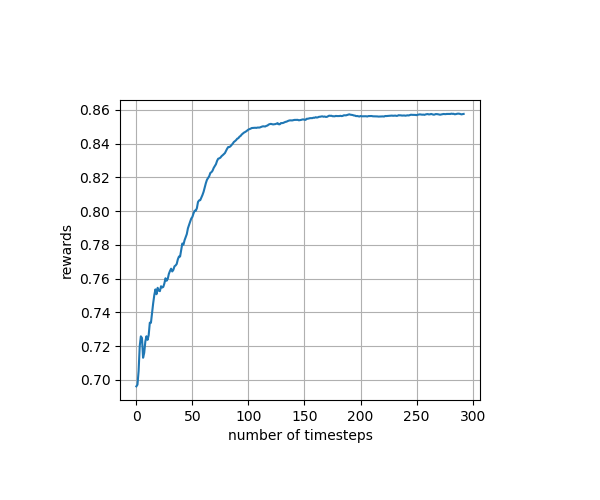

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.3, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.5],
                                episode_limit_array=[150000], 
                                log_dir=log_dir,
                                seed=seed)